In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

from lifelines.plotting import plot_lifetimes      # Lifeline package for the Survival Analysis
%pylab inline
figsize(12,6)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Нещодавно я зіткнувся з новою для мене бібліотекою lifelines. Я трохи подивився, як люди нею користуються, і прочитав невелику статтю. Я захотів зробити маленький простий аналіз за допомогою цієї бібліотеки та кинути цей ноутбук до мого портфоліо. За основу візьмемо датасет з платформи Kaggle. Метою там був прогноз поведінки, щоб утримувати клієнтів. Скажу чесно, зараз я не є експертом з прогнозів, так як це є цілий розділ з ML, хоча якусь логістичну регресію можливо сюди б можна було застосувати. Зараз в мене на меті просто базово проаналізувати датасет, включаючи нову бібліотеку. Я хочу подивитися на відтік, або так званий Churn Rate, та візуалізувати цю метрику включаючи різні фактори.[Приклади наборів даних IBM]. Посилання:https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data

### Змінні
- customerID : ідентифікатор клієнта
- стать: чи є клієнт чоловіком чи жінкою
- SeniorCitizen : чи є клієнт пенсіонером чи ні (1, 0)
- Партнер: чи є у клієнта партнер чи ні (так, ні)
- Утриманці: чи є у клієнта утриманці чи ні (так, ні)
- термін перебування: кількість місяців, протягом яких клієнт працював у компанії
- PhoneService: чи є у клієнта телефонна служба чи ні (так, ні)
- MultipleLines: чи є у клієнта кілька ліній чи ні (так, ні, немає телефонної служби)
- InternetService: Інтернет-провайдер Клієнта (DSL, Оптоволокно, Ні)
- OnlineSecurity: чи є у клієнта онлайн-захист чи ні (так, ні, немає інтернет-послуги)
- Онлайн-резервне копіювання: чи є у клієнта онлайн-резервне копіювання чи ні (так, ні, немає інтернет-послуги)
- DeviceProtection: чи є у клієнта захист пристрою чи ні (так, ні, немає Інтернет-послуги)
- Технічна підтримка: чи має клієнт технічну підтримку чи ні (так, ні, немає Інтернет-послуги)
- StreamingTV : чи має клієнт потокове телебачення чи ні (так, ні, немає інтернет-послуги)
- StreamingMovies: чи є у клієнта потокове передавання фільмів чи ні (так, ні, немає інтернет-послуги)
- Контракт: термін дії контракту замовника (місяць до місяця, один рік, два роки)
- PaperlessBilling : чи використовує клієнт безпаперовий біллінг чи ні (так, ні)
- PaymentMethod: спосіб оплати клієнта (електронний чек, чек поштою, банківський переказ (автоматичний), кредитна картка (автоматичний))
- MonthlyCharges : сума, що стягується з клієнта щомісяця
- TotalCharges : загальна сума, стягнута з клієнта
- Відтік: чи відтік клієнт чи ні (так чи ні)

Основною роботою буде аналіз місяців, і ми обов'язково розглянемо, який відсоток клієнтів переходить саме на нову передплату. Ми не виключаємо можливість, що ті, хто взяв підписку лише на один місяць, можуть не відмовлятися від послуг, а просто оновлювати підписку. Крім того, мене цікавить підхід пенсіонерів до передплати. На мою думку, ці люди, насамперед, беруть довгострокову перспективу і, можливо, віддають перевагу довгостроковим передплатам.

In [92]:
import pandas as pd

df = pd.read_csv("C:/Users/tuf/Downloads/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


подивимося на максимальне значення за період

In [25]:
df.tenure.max()

72

In [26]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [96]:
# Convert TotalCharges to numeric
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

# Replace 'YES' and No to 1 and 0.
df['Churn']=df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )

In [97]:
# Fill the null value with the median value

df.TotalCharges.fillna(value=df['TotalCharges'].median(),inplace=True)

In [98]:
# Create a list of Categorical Columns
cat_cols= [i  for i in df.columns if df[i].dtype==object]
cat_cols.remove('customerID') 


Як я вже говорив, мені б дуже хотілося подивитись на людей для перевірки моєї гіпотези, чи перейшли вони з помісячної оплати, наприклад, на річну. Але дані так влаштовані, що тут присутні лише унікальні користувачі, тому здійснити це неможливо.

### Simple Kaplan Meier

<Axes: xlabel='timeline'>

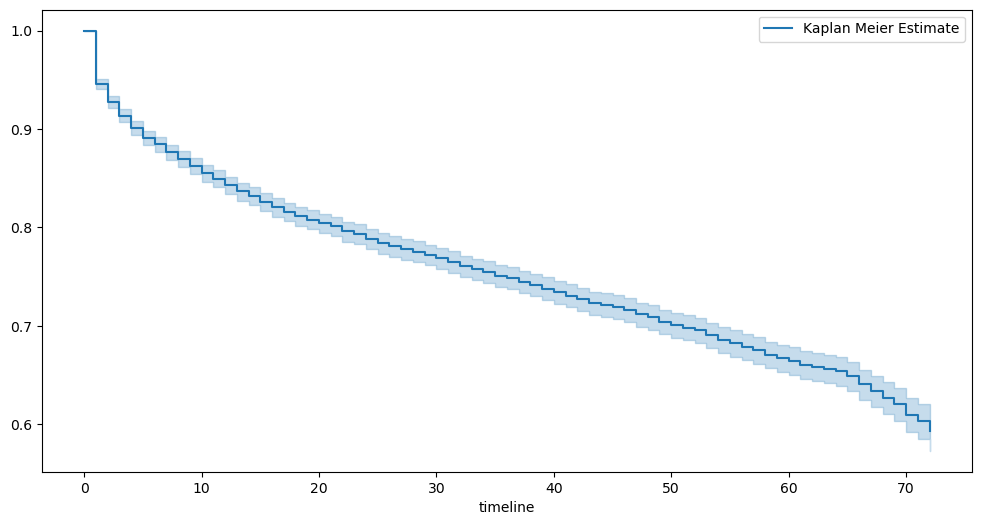

In [101]:


# Lets create an overall KaplanMeier curve, without breaking it into groups of covariates
from lifelines import KaplanMeierFitter


durations = df['tenure'] #
#Time to event data of censored and event data


event_observed = df['Churn']  
# It has the churned (1) and censored is (0)


km = KaplanMeierFitter() 
# instantiate the class to create an object


km.fit(durations, event_observed,label='Kaplan Meier Estimate')
km.plot()



можемо побачити що спадає приблизно на 40 % наша пряма якщо брати в загальному вигляді всі метрики

Ми можемо зробити висновок з цього факту, але давайте також розглянемо більш детальну інформацію, щодо нашої ситуації, включаючи інші метрики.







Давайте розглянемо, на скільки падає наш Churn Rate за трьома категоріями. Ми можемо спостерігати, що найбільше звідти виходять користувачі, які брали підписку на місяць. Можна припустити, що вони брали її та їм не сподобалось, або вони перейшли саме на нову підписку. У будь-якому випадку, це свого роду пробний період, і на його основі ми можемо запропонувати людям додаткові 'плюшки', щоб стимулювати їх придбати підписку на більший період.





А далі вже спостерігається менш різкий спад наших двох метрик. Ми можемо побачити, що метрика з дворічною підпискою йде у відтік менше, ніж у інших випадках. Це може свідчити про те, що люди справді цінують цю підписку і регулярно нею користуються. Також це може говорити про те, що просто кількість клієнтів з часом зменшується та про те, що просто людей менше і менше, ж зразу дій.

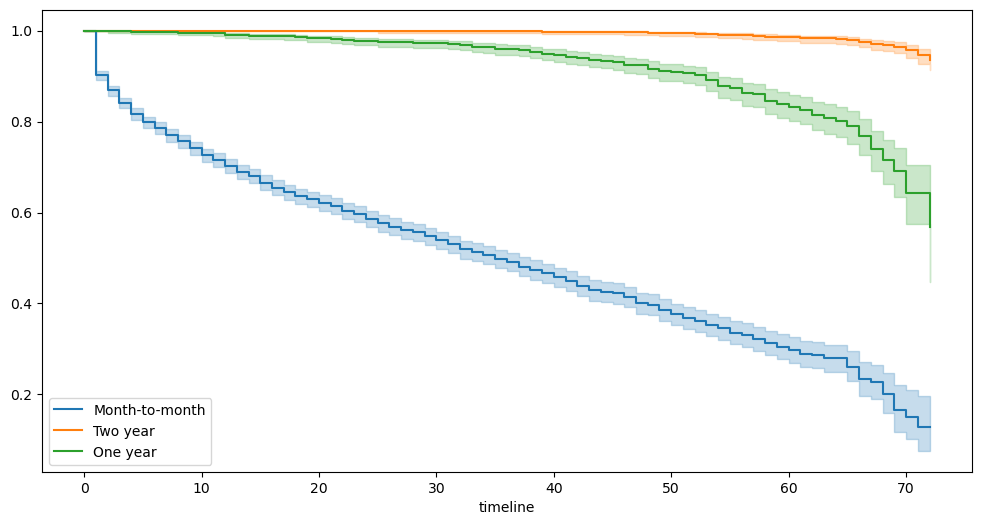

In [103]:
kmf = KaplanMeierFitter() 


T = df['tenure']     #time to event
E = df['Churn']      #event occurred or censored


groups = df['Contract']             
ix1 = (groups == 'Month-to-month')   # Cohort 1
ix2 = (groups == 'Two year')         # Cohort 2
ix3 = (groups == 'One year')         # Cohort 3


kmf.fit(T[ix1], E[ix1], label='Month-to-month')    # fit the cohort 1 data
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='Two year')         # fit the cohort 2 data
ax1 = kmf.plot(ax=ax)


kmf.fit(T[ix3], E[ix3], label='One year')        # fit the cohort 3 data
kmf.plot(ax=ax1);                                


In [105]:
df.Contract.value_counts()

Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

Так, ми бачимо, що більшість користувачів знаходяться в категорії "Month-to-month", що є цілком логічним, оскільки тут можуть бути як клієнти з пробним періодом, так і ті, хто вибрав цю опцію на короткий термін. Стосовно інших двох категорій, на мою думку, тут достатно даних, тому не можна сказати що лінії на графіках були 'шумові'. У принципі, можна сказати, що менше відтікає саме в категоріях "Two year" і "One year".








Далі, я хотів би подивитись, на які категорії сидять більш пенсіонери. За логікою, такі люди повинні брати підписку на довгий термін.

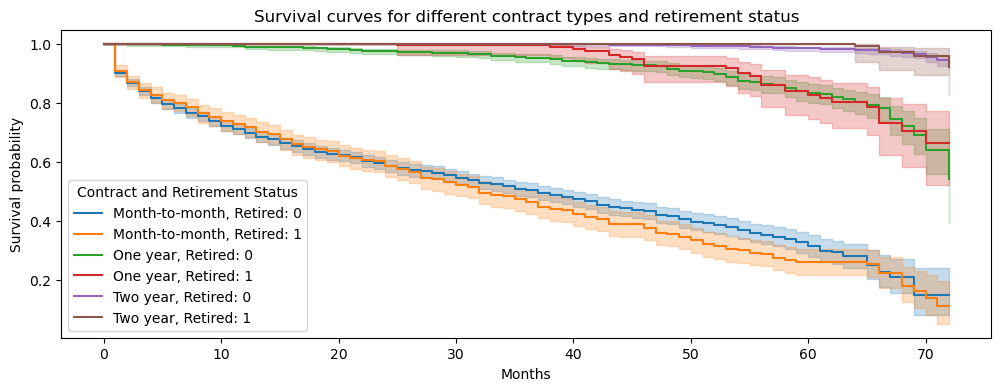

In [50]:
plt.figure(figsize=(12,4))


kmf = KaplanMeierFitter() 

T = df['tenure']     #time before event
E = df['Churn']      #event occurred or was censored

# Separation of data by type of contract and pensioner status
for contract_type in df['Contract'].unique():
    for is_retired in df['SeniorCitizen'].unique():
        mask = (df['Contract'] == contract_type) & (df['SeniorCitizen'] == is_retired)
        label = f'{contract_type}, Retired: {is_retired}'
        kmf.fit(T[mask], event_observed=E[mask], label=label)
        kmf.plot()

plt.xlabel('Months')
plt.ylabel('Survival probability')
plt.title('Survival curves for different contract types and retirement status')
plt.legend(title='Contract and Retirement Status')
plt.show()

Ми можемо побачити, що ті люди, які на пенсії, припинили брати щомісячну підписку після приблизно 26 місяців, і на графіку видно, що вони почали попадати в відтік. Далі нам треба буде простежити той факт, що вони або пішли, або перейшли на інший тип підписки. Також ми бачимо, що ситуація з динамікою тих, хто на пенсії і обрав підписку на рік, дуже добра, і на позначках в місяцях на 45 значно більше пенсіонерів брали цю підписку, ніж ті, хто не на пенсії, а потім, з певною мірою, це зрівнялося. Можна також побачити закономірність у тому, що деякі користувачі вирішили перейти відразу на дворічну підписку. І в разі останньої ми бачимо мінімальний відтік, який йде саме з підпискою на два роки. Перевіримо також, скільки людей на якій передплаті.

In [52]:
df.Contract.value_counts()

Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

Ми бачимо, що частково "Two year" і "One year" досить схожі і не мають суттєвих відмінностей, але "Month-to-month" підписку обирають саме ті, хто хоче спробувати.

In [57]:
t = df[['customerID', 'Contract']]

Я хотів знайти те, як люди переходять з однієї підписки до іншої, але я казав, всі ID унікальні, тоді, на жаль, ми не зможемо порахувати таку річ.

In [60]:
t.customerID.value_counts()

customerID
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: count, Length: 7043, dtype: int64

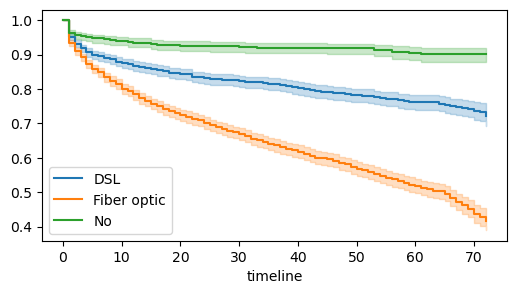

In [107]:
plt.figure(figsize=(6,3))

kmf = KaplanMeierFitter() 


T = df['tenure']     # time to event
E = df['Churn']      # event occurred or censored


groups = df['InternetService']  # Create the cohorts from the 'Contract' column
ix1 = (groups == 'DSL')         # Cohort 1
ix2 = (groups == 'Fiber optic') # Cohort 2
ix3 = (groups == 'No')          # Cohort 3


kmf.fit(T[ix1], E[ix1], label='DSL')  
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='Fiber optic')        
ax1 = kmf.plot(ax=ax)


kmf.fit(T[ix3], E[ix3], label='No')        
kmf.plot(ax=ax1);                                 
#Plot the KM curve for three cohort on same x and y axis


Також я захотів подивитись, на як відтікають користувачі з точки зору типу інтернет-сервісу (InternetService).

In [108]:
df.InternetService.unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)


1. **DSL (Digital Subscriber Line)**: DSL – це технологія доступу до інтернету, яка використовує стандартні мідні телефонні лінії для передачі даних. Він зазвичай надає середні швидкості передачі даних і може бути доступним для користувачів, які знаходяться на певній відстані від центрального вузла. DSL є одним з найпоширеніших методів доступу до інтернету, особливо в областях, де доступні телефонні лінії, але не оптоволоконні кабелі.

2. **Оптоволокно (Fiber Optic)**: Оптоволокно - це технологія передачі даних, що використовує скляні або пластикові волокна для передачі світлових сигналів. Це забезпечує значно більш високу швидкість передачі даних і більшу пропускну здатність в порівнянні з DSL. Оптоволоконний інтернет часто є кращим вибором для користувачів, яким доступні оптоволоконні кабелі, оскільки він забезпечує більш стабільне та швидке з'єднання.

3. **Ні (No)**: Цей варіант означає, що клієнт не використовує інтернет-провайдера для доступу до інтернету. Це може бути варіант для користувачів, які вважають за краще не мати інтернет-з'єднання вдома або використовують інші методи доступу до Інтернету, такі як мобільний інтернет або громадські точки доступу Wi-Fi.

можливо у людей яких гарна швидкість інтернету,в них немає як такого бажання купляти підписку. А з точки зору людей яких 'No'
інтернет можна висунути такі варіанти : 

1. Відсутність залежності від сервісів: Клієнти без інтернету, ймовірно, не залежать від онлайн-сервісів так сильно, як ті, хто має доступ до інтернету. Вони можуть бути менш схильні до зміни провайдера, тому що їм не потрібні онлайн-сервіси або вони використовують альтернативні способи спілкування або розваг.

2. Стабільність послуг: Клієнти без інтернету можуть віддавати перевагу стабільності послуг та бути більш лояльними до свого поточного провайдера. Вони можуть розглядати інтернет як необхідність, а не як основний засіб зв'язку, тому можуть бути схильні до зміни провайдера.

3. Економічні міркування: Клієнти без інтернету можуть бути більш економічно обмежені і віддавати перевагу залишатися з поточним провайдером через вартість послуг або доступність альтернативних варіантів.




Також в нашому випадку кількість користувачів без доступу до Інтернету менша за всіх, тому статистика може показувати, що відтік клієнтів більше в тій групі, де є більше користувачів.







In [68]:
df.InternetService.value_counts()

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

In [77]:
t = df.InternetService.value_counts().to_frame().reset_index()

In [78]:
t.head()

,InternetService,count
0,Fiber optic,3096
1,DSL,2421
2,No,1526


<Axes: xlabel='InternetService', ylabel='count'>

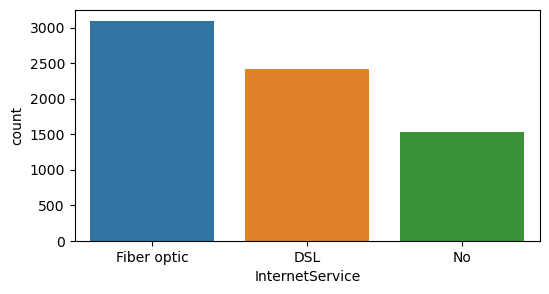

In [80]:
plt.figure(figsize=(6,3))
sns.barplot(data = t, x = 'InternetService', y ='count')

StreamingTV : чи має клієнт потокове телебачення чи ні (так, ні, немає інтернет-послуги)

 StreamingMovies: чи є у клієнта потокове передавання фільмів чи ні (так, ні, немає інтернет-послуги)

<Axes: xlabel='timeline'>

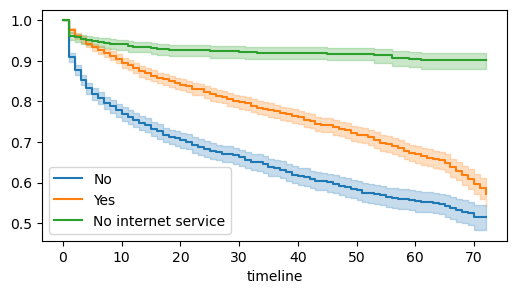

In [86]:
plt.figure(figsize=(6, 3))

kmf = KaplanMeierFitter() 

T = df['tenure']      
E = df['Churn']      

groups = df['StreamingMovies'].str.strip()  
ix1 = (groups == 'No')   # Cohort 1
ix2 = (groups == 'Yes')  # Cohort 2
ix3 = (groups == 'No internet service')  # Cohort 3

kmf.fit(T[ix1], E[ix1], label='No')    # fit the cohort 1 data
ax = kmf.plot()

kmf.fit(T[ix2], E[ix2], label='Yes')         #fit the cohort 2 data
ax1 = kmf.plot(ax=ax)

kmf.fit(T[ix3], E[ix3], label='No internet service')        # fit the cohort 3 data
kmf.plot(ax=ax1)                                 # Plot the KM curve for three cohort on same x and y axis


Невикористання інтернет-послуг IBM: Клієнти можуть використовувати послуги IBM, але не включати до свого пакету інтернет-сервіси компанії.
Щодо інших двох груп, люди з функцією "StreamingMovies", здається, для них менше приводу не брати підписку, проте, як можемо бачити на графіку, жовта лінія все одно йде на спад.

І на останок, ми зробимо все ж таке саме, але по StreamingTV. І як можемо бачити, люди, які мають підписку на StreamingTV, йдуть менш до відтіку, ніж люди, які не мають. Можливо, знову, це пов'язано з тим, що ці користувачі мають більше альтернативних варіантів на ринку інтернет-послуг, які краще відповідають їхнім потребам і очікуванням, або з тим, що вони не отримують додаткових послуг, які їм можуть бути потрібні або які вони хотіли би отримувати разом з інтернет-послугами.

<AxesSubplot:xlabel='timeline'>

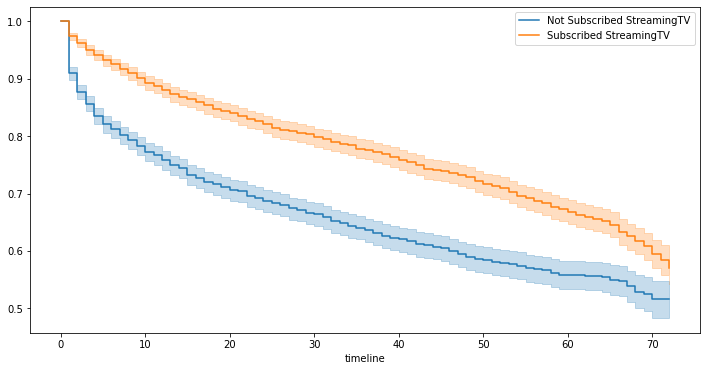

In [13]:
kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

## Two Cohorts are compared. 1. Streaming TV Not Subsribed by Users, 2. Streaming TV subscribed by the users.
groups = df['StreamingTV']   
i1 = (groups == 'No')      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == 'Yes')     ## group i2 , having the pandas series for the 2nd cohort


## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Not Subscribed StreamingTV')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Subscribed StreamingTV')
kmf1.plot(ax=a1)